In [297]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.preprocessing import StandardScaler

In [298]:
signal = pd.read_csv("numbers-on-unemployment-benefits1.csv")
signal.columns = ['month', 'num']
signal = signal[:439]
signal.num = signal.num.fillna(0)
signal_u = signal
signal = signal.num

In [299]:
len(signal)

439

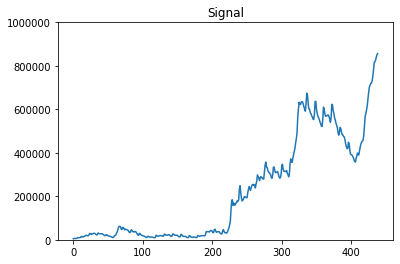

In [300]:
plt.plot(signal)
plt.ylim(0,1000000)
plt.title("Signal")
plt.show()

In [301]:
max(signal)

856505.0

In [302]:
signal_n = signal.values
signal_n = signal_n.reshape((len(signal_n), 1))

In [303]:
scaler = MinMaxScaler(feature_range=(0, 1))
signal_n = scaler.fit_transform(signal_n)

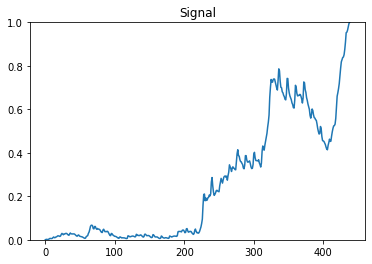

In [304]:
plt.plot(signal_n)
plt.ylim(0,1)
plt.title("Signal")
plt.show()

In [305]:
class MeanDetector:
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    def check(self, new_signal_value): 
        threshold_level = self.mean * self.threshold
        
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

In [306]:
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    
    plt.figure(figsize=(14,8))
    plt.plot(signal, 'b.')
    plt.plot(signal, 'b-', alpha=0.15)
    plt.title('Signal')
    
    if stop_points:
        plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                      colors='r', linestyles='dotted')
    
    plt.show()

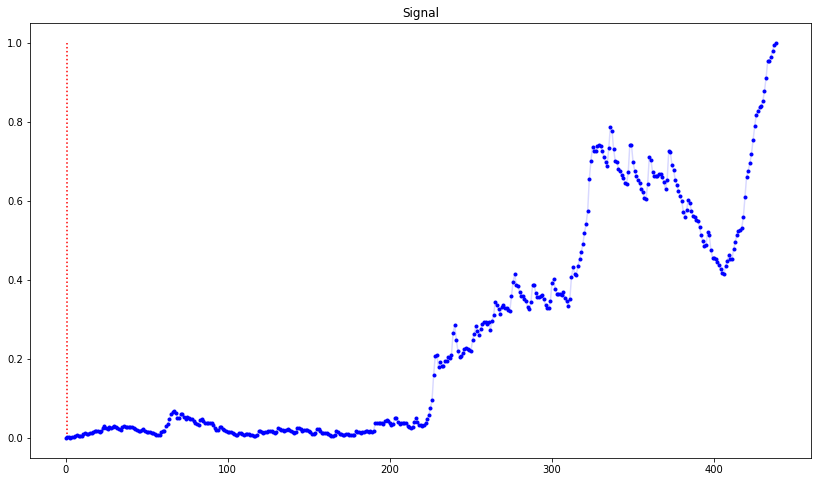

In [307]:
simulate(MeanDetector(threshold=0.0000000005), signal_n)

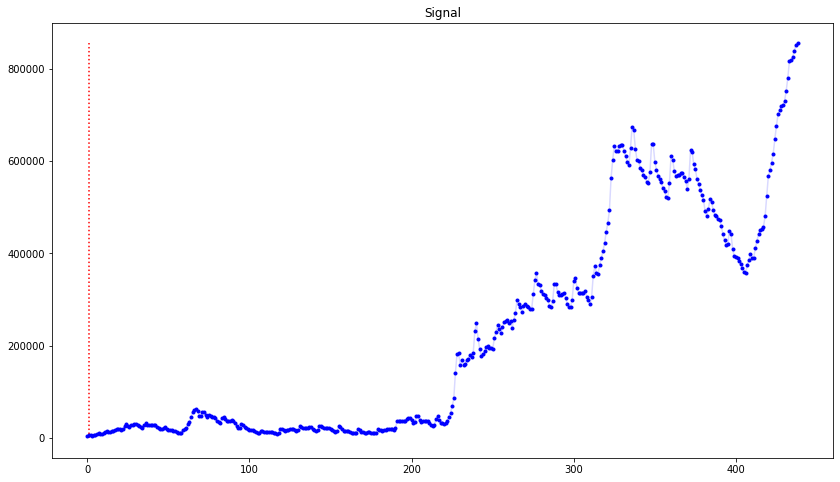

In [308]:
simulate(MeanDetector(), signal)

На нормализованных данных не страбатывает. Но тут как понимаю вопрос имено в части среднего и предела - подобрать его не получилось

In [309]:
class ZScoreDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

e:\Users\chefranov_as\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
e:\Users\chefranov_as\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


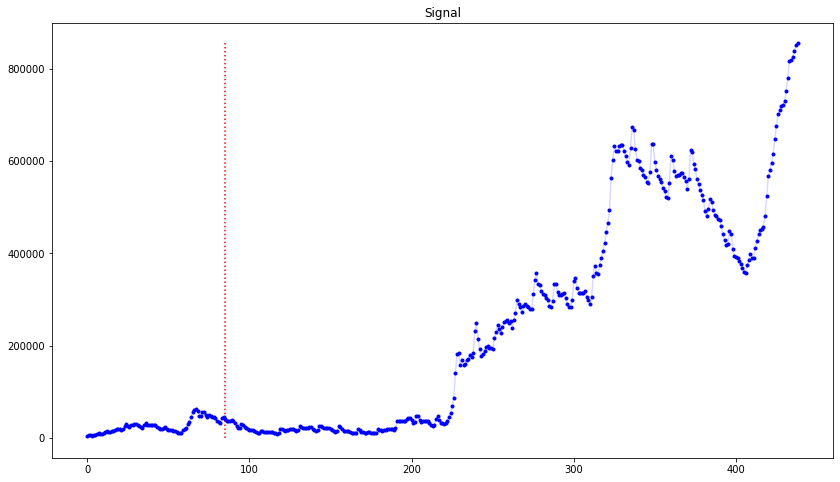

In [310]:
simulate(ZScoreDetector(window_size=30, threshold=5.0), signal)

In [311]:
__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

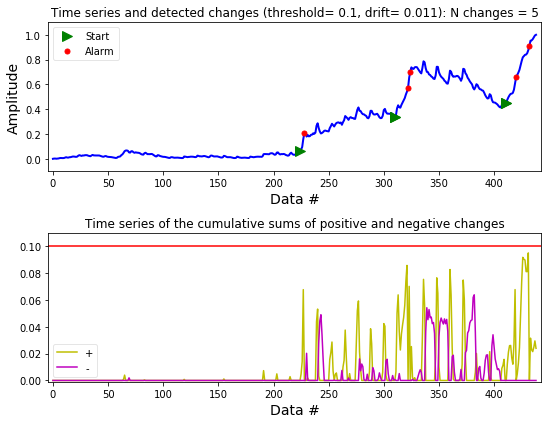

(array([228, 322, 324, 420, 432]),
 array([224, 310, 310, 411, 411]),
 array([], dtype=int32),
 array([], dtype=float64))

In [312]:
detect_cusum(signal_n, threshold=0.1, drift=0.011, ending=False, show=True)

In [313]:
clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)
clf.fit(signal_n[:350])

y_pred_train = clf.predict(signal_n[:350])
y_pred_test = clf.predict(signal_n[350:])

In [314]:
false_positive_train = []
false_positive_test = []
for i, t in enumerate(y_pred_train):
    if t != 1:
        false_positive_train.append((i, signal_n[i]))
        
for i, t in enumerate(y_pred_test):
    if t != 1:
        idx = len(y_pred_train) + i
        false_positive_test.append((idx, signal_n[idx]))

In [315]:
false_positive_train = np.array(false_positive_train)
false_positive_test = np.array(false_positive_test)

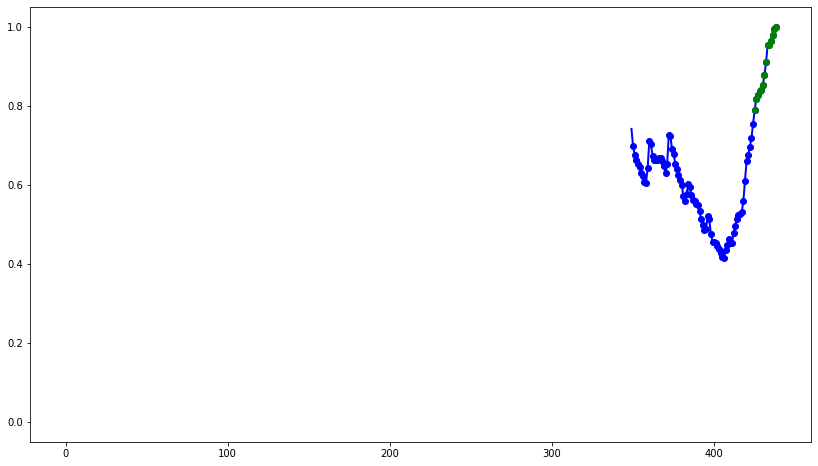

In [316]:
plt.figure(figsize=(14,8))
plt.plot(range(350), signal_n[:350], 'wo', linewidth=10)
plt.plot(range(350), signal_n[:350], 'w-', linewidth=2)
plt.plot(range(350,439), signal_n[350:], 'bo', linewidth=10)
plt.plot(range(349,439), signal_n[349:], 'b-', linewidth=2)
#plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')
plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
plt.show()

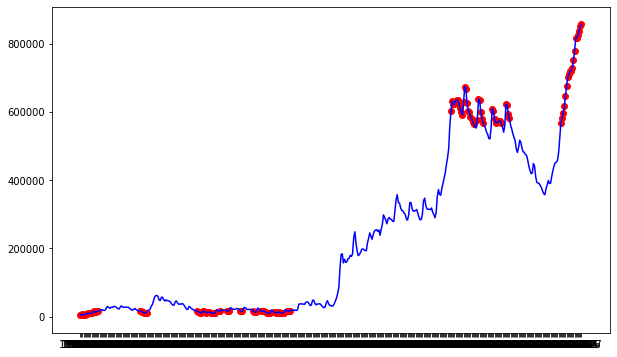

In [317]:
data = signal_n
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = svm.OneClassSVM(nu=0.3, kernel="rbf", gamma=0.01)
model.fit(data)
signal_u['anomaly3'] = pd.Series(model.predict(data))

fig, ax = plt.subplots(figsize=(10,6))
a = signal_u.loc[signal_u['anomaly3'] == -1, ['month', 'num']] #anomaly

ax.plot(signal_u['month'], signal_u['num'], color='blue')
ax.scatter(a['month'],a['num'], color='red')
plt.show();

In [318]:
def one_class_SVM_anomaly_detection(dataframe, columns_to_filter_by, outliers_fraction):
    """
    In this definition, time series anomalies are detected
    using a One Class SVM algorithm.
    Arguments:
        df: Pandas dataframe
        columns_to_filter_by: string, or list of strings. Name of the column(s) that 
        we want to use in the One Class SVM to detect time series anomalies
        outliers_fraction: float. Percentage of outliers allowed in the sequence.
    Outputs:
        df: Pandas dataframe with column for detected One Class SVM anomalies (True/False)
    """
    #Subset the dataframe by desired columns
    dataframe_filtered_columns=dataframe[columns_to_filter_by]
    #Transform the data using the fit_transform() function
    min_max_scaler = StandardScaler()
    np_scaled = min_max_scaler.fit_transform(dataframe_filtered_columns)
    scaled_dataframe = pd.DataFrame(np_scaled)
    #Remove any NaN's from the dataframe
    scaled_dataframe =scaled_dataframe.dropna()
    #Train the One Class SVM
    model = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
    model.fit(scaled_dataframe)
    #Create a column for the anomaly
    one_class_svm_anomaly_column='One_Class_SVM_Anomaly'
    scaled_dataframe[one_class_svm_anomaly_column] = pd.Series(model.predict(
                                                        scaled_dataframe)).map({1: False, -1: True})
    dataframe[one_class_svm_anomaly_column] = scaled_dataframe[one_class_svm_anomaly_column]
    return dataframe


In [323]:
signal_u_df=one_class_SVM_anomaly_detection(dataframe=signal_u, 
                                    columns_to_filter_by=['num'], 
                                    outliers_fraction=.3)

In [324]:
signal_u_df.head()

,month,num,anomaly3,One_Class_SVM_Anomaly
0,1956-01,4742.0,-1,True
1,1956-02,6128.0,-1,True
2,1956-03,6494.0,-1,True
3,1956-04,5379.0,-1,True
4,1956-05,6011.0,-1,True


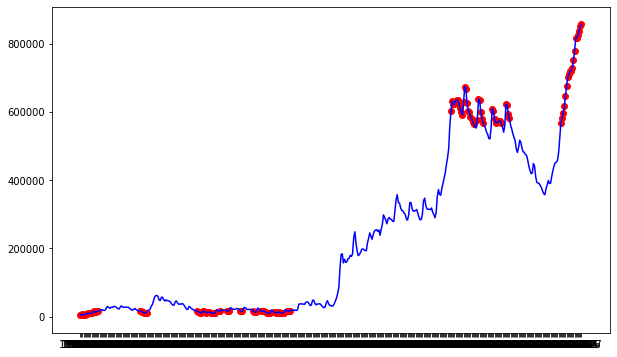

In [326]:
fig, ax = plt.subplots(figsize=(10,6))
a = signal_u_df.loc[signal_u_df['One_Class_SVM_Anomaly'] == True, ['month', 'num']] #anomaly

ax.plot(signal_u_df['month'], signal_u_df['num'], color='blue')
ax.scatter(a['month'],a['num'], color='red')
plt.show();

https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46
https://www.researchgate.net/post/How_to_use_One_Class_SVM_for_time_series_data
https://medium.com/ro-data-team-blog/ro-spends-a-significant-amount-of-money-on-commercials-especially-on-tv-e38eaac17735
https://techrando.com/2019/08/23/unsupervised-machine-learning-approaches-for-outlier-detection-in-time-series/